In [1]:
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [275]:
def load_and_preprocess_image(path):
    #load img
    image = tf.io.read_file(path)
    #preprocess
    #image = tf.cond(
     #   tf.image.is_jpeg(image),
      #  lambda: tf.image.decode_jpeg(image, channels=3),
       # lambda: tf.image.decode_png(image, channels=3))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (56, 56))
    image = (image - 127.5) / 127.5  # [-1, 1]
    
    return image

In [276]:
def load_normalized_dataset(path):
    image_samples_path = list()
    class_count = 1
    for class_dir in os.listdir(path):
        img_sample_count = 1
        full_class_dir = os.path.join(path, class_dir)
        for image_name in os.listdir(full_class_dir):
            full_image_name = os.path.join(full_class_dir, image_name)
            image_samples_path.append(full_image_name)
            img_sample_count += 1
        class_count += 1

    random.shuffle(image_samples_path)
    scene_dataset = tf.data.Dataset.from_tensor_slices(image_samples_path)
    scene_dataset = scene_dataset.map(load_and_preprocess_image)
    batch_size = 256
    scene_dataset = scene_dataset.batch(batch_size)

    return scene_dataset

In [277]:
scene_dataset = load_normalized_dataset("../data")
print(list(scene_dataset.as_numpy_iterator()))
scene_dataset

[array([[[[-0.15623246, -0.15623246, -0.15623246],
         [-0.13123247, -0.13123247, -0.13123247],
         [-0.12892157, -0.12892157, -0.12892157],
         ...,
         [-0.44362745, -0.4122549 , -0.40441176],
         [-0.42507002, -0.39369747, -0.38585433],
         [-0.45462185, -0.4232493 , -0.43109244]],

        [[-0.20352766, -0.20352766, -0.20352766],
         [-0.17955178, -0.17955178, -0.17955178],
         [-0.12892157, -0.12892157, -0.12892157],
         ...,
         [-0.44362745, -0.4122549 , -0.40441176],
         [-0.45574233, -0.42436978, -0.41652665],
         [-0.4502801 , -0.41890755, -0.4267507 ]],

        [[-0.2082896 , -0.2082896 , -0.2082896 ],
         [-0.1507703 , -0.1507703 , -0.1507703 ],
         [-0.15252979, -0.15252979, -0.15252979],
         ...,
         [-0.4261905 , -0.39481795, -0.3869748 ],
         [-0.4002188 , -0.36884627, -0.36100313],
         [-0.38165265, -0.3502801 , -0.35812324]],

        ...,

        [[-0.54509807, -0.5137255 , -

<_BatchDataset element_spec=TensorSpec(shape=(None, 56, 56, 3), dtype=tf.float32, name=None)>

In [278]:
def generator():
    model = keras.Sequential([
        layers.Dense(units=7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),

        layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),

        layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.01),

        layers.Conv2DTranspose(filters=3, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False,
                               activation="tanh"),
    ])
    return model

In [279]:
gen_model = generator()
gen_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_36 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_36 (Conv2  (None, 7, 7, 128)         294912    
 DTranspose)                                                     
                                                                 
 batch_normalization_37 (Ba  (None, 7, 7, 128)       

In [280]:
def generator_loss(fake_output):
    cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [281]:
def generator_optimizer():
    return tf.optimizers.Adam(1e-4)

In [282]:
gen_optimizer = generator_optimizer()

In [283]:
def discriminator():
    model = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                      input_shape=[56, 56, 3]),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(rate=0.3),

        layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(rate=0.3),

        layers.Flatten(),
        layers.Dense(units=1),
    ])
    return model

In [284]:
dis_model = discriminator()
dis_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 128)       3584      
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 28, 28, 128)       0         
                                                                 
 dropout_18 (Dropout)        (None, 28, 28, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_19 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_9 (Flatten)         (None, 12544)           

In [285]:
def discriminator_loss(real_output,
                       fake_output):
    cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [286]:
def discriminator_optimizer():
    return tf.optimizers.Adam(1e-4)

In [287]:
dis_optimizer = discriminator_optimizer()

In [288]:
def train_step(images, gen_model, gen_optimizer, dis_model, dis_optimizer, gen_loss_metric, dis_loss_metric):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen_model(noise, training=True)

        real_output = dis_model(images, training=True)
        fake_output = dis_model(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, gen_model.trainable_variables))
    dis_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))

    gen_loss_metric(gen_loss)
    dis_loss_metric(disc_loss)



In [289]:
def test_step(real_images, gen_model, dis_model):
    random_seed = tf.random.normal([256, 100])
    fake_images = gen_model(random_seed, training=False)

    real_dis_prediction = dis_model(real_images)
    fake_dis_prediction = dis_model(fake_images)

    correct = len(real_dis_prediction[real_dis_prediction >= 0.0])
    wrong = len(real_dis_prediction[real_dis_prediction < 0.0])
    real_dis_acc = float(correct) / float(correct + wrong)

    correct = len(fake_dis_prediction[fake_dis_prediction < 0.0])
    wrong = len(fake_dis_prediction[fake_dis_prediction >= 0.0])
    fake_dis_acc = float(correct) / float(correct + wrong)

    combined_dis_acc = (real_dis_acc + fake_dis_acc) / 2

    return real_dis_acc, fake_dis_acc, combined_dis_acc

In [290]:
def loss_and_accuracy(gen_loss_metric, epoch, dis_loss_metric, real_dis_acc, fake_dis_acc, combined_dis_acc):
    print('Loss')
    print('Generator:{}'.format(gen_loss_metric.result()))
    print('Discriminator:{}'.format(dis_loss_metric.result()))
    print('Accuracy')
    print('Real Discriminator:{}'.format(real_dis_acc))
    print('Fake Discriminator:{}'.format(fake_dis_acc))
    print('Combined Discriminator:{}'.format(combined_dis_acc))
    gen_loss_metric.reset_states()
    dis_loss_metric.reset_states()

In [291]:
def weights_and_biases(gen_model, epoch, dis_model):
    print('Generator Weights')
    for gen_layer in gen_model.layers:
        print(gen_layer.name + ':{}'.format(gen_layer.get_weights()[0]))
        print('Discriminator')
        for dis_layer in dis_model.layers:
            print('Weights')
            print(dis_layer.name + ':{}'.format(dis_layer.get_weights()[0]))
            print('Biases')
            print(dis_layer.name + ':{}'.format(dis_layer.get_weights()[1]))

In [292]:
def save_image(gen_model, epoch, train_summary_writer):
    test_input = tf.random.normal([10, 100])
    predictions = None
    predictions = gen_model(test_input, training=False)
    for i in range(predictions.shape[0]):
        img = np.array(predictions[i]) * 127.5 + 127.5
        img = img.astype(np.uint8, copy=False)
        plt.imsave('../res/image_at_epoch_{:05d}_{:05d}.png'.format(epoch, i), img)
    with tf.name_scope("Samples"):
        with train_summary_writer.as_default():
            for i in range(predictions.shape[0]):
                img = np.array(np.array(predictions[i]) * 0.5 + 0.5).astype(np.float32)
                img = np.reshape(img, (1, 56, 56, 3))
                tf.summary.image('../res2/image_{:03d}.png'.format(i), img, step=epoch)

In [316]:
def generate_and_save_images(model, epoch):
    test_input = tf.random.normal([9, 100])
    predictions = gen_model(test_input, training=False)
    fig = plt.figure(figsize=(3, 3))
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        img = np.array(predictions[i]) * 127.5 + 127.5
        img = img.astype(np.uint8, copy=False)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig('../res/gif2/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [317]:
def train(real_image_dataset,  epochs, gen_model, gen_optimizer, dis_model, dis_optimizer):
    gen_loss_metric = keras.metrics.Mean('train_loss', dtype=tf.float32)
    dis_loss_metric = keras.metrics.Mean('train_loss', dtype=tf.float32)
    for epoch in range(epochs):
        print('Epoch {}'.format(epoch))
        for image_batch in real_image_dataset:
            train_step(image_batch, gen_model, gen_optimizer, dis_model, dis_optimizer, gen_loss_metric, dis_loss_metric)
            real_dis_acc, fake_dis_acc, combined_dis_acc = test_step(image_batch, gen_model, dis_model)
            loss_and_accuracy(gen_loss_metric, epoch, dis_loss_metric, real_dis_acc, fake_dis_acc, combined_dis_acc)
        #save_image(gen_model, epoch + 1, train_summary_writer)
        generate_and_save_images(gen_model, epoch + 1)

Epoch 0
Loss
Generator:1.778428554534912
Discriminator:0.6734799146652222
Accuracy
Real Discriminator:0.7890625
Fake Discriminator:1.0
Combined Discriminator:0.89453125
Loss
Generator:1.7004226446151733
Discriminator:0.6430133581161499
Accuracy
Real Discriminator:0.765625
Fake Discriminator:1.0
Combined Discriminator:0.8828125
Loss
Generator:1.6344283819198608
Discriminator:0.6796889305114746
Accuracy
Real Discriminator:0.75
Fake Discriminator:0.99609375
Combined Discriminator:0.873046875
Loss
Generator:1.4330556392669678
Discriminator:0.650486946105957
Accuracy
Real Discriminator:0.76171875
Fake Discriminator:1.0
Combined Discriminator:0.880859375
Loss
Generator:1.4994877576828003
Discriminator:0.675071120262146
Accuracy
Real Discriminator:0.75
Fake Discriminator:1.0
Combined Discriminator:0.875
Loss
Generator:1.5839053392410278
Discriminator:0.6394894123077393
Accuracy
Real Discriminator:0.76171875
Fake Discriminator:1.0
Combined Discriminator:0.880859375
Loss
Generator:1.68921470642

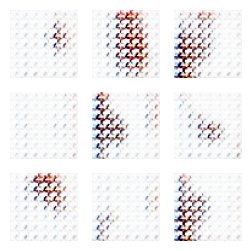

Epoch 1
Loss
Generator:1.9115734100341797
Discriminator:0.5418689250946045
Accuracy
Real Discriminator:0.78515625
Fake Discriminator:1.0
Combined Discriminator:0.892578125
Loss
Generator:1.965192437171936
Discriminator:0.5779707431793213
Accuracy
Real Discriminator:0.765625
Fake Discriminator:1.0
Combined Discriminator:0.8828125
Loss
Generator:1.8492035865783691
Discriminator:0.6292994618415833
Accuracy
Real Discriminator:0.765625
Fake Discriminator:0.99609375
Combined Discriminator:0.880859375
Loss
Generator:1.6070332527160645
Discriminator:0.5894725918769836
Accuracy
Real Discriminator:0.80859375
Fake Discriminator:0.98046875
Combined Discriminator:0.89453125
Loss
Generator:1.4189512729644775
Discriminator:0.609824538230896
Accuracy
Real Discriminator:0.78515625
Fake Discriminator:0.99609375
Combined Discriminator:0.890625
Loss
Generator:1.5564671754837036
Discriminator:0.5999941825866699
Accuracy
Real Discriminator:0.7734375
Fake Discriminator:1.0
Combined Discriminator:0.88671875
L

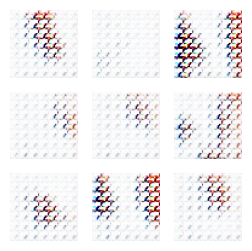

Epoch 2
Loss
Generator:1.9453155994415283
Discriminator:0.5384848713874817
Accuracy
Real Discriminator:0.80859375
Fake Discriminator:1.0
Combined Discriminator:0.904296875
Loss
Generator:1.9471930265426636
Discriminator:0.5343800783157349
Accuracy
Real Discriminator:0.79296875
Fake Discriminator:1.0
Combined Discriminator:0.896484375
Loss
Generator:1.7776515483856201
Discriminator:0.600002646446228
Accuracy
Real Discriminator:0.78125
Fake Discriminator:0.984375
Combined Discriminator:0.8828125
Loss
Generator:1.5884971618652344
Discriminator:0.5747321844100952
Accuracy
Real Discriminator:0.796875
Fake Discriminator:0.97265625
Combined Discriminator:0.884765625
Loss
Generator:1.5326056480407715
Discriminator:0.5787200331687927
Accuracy
Real Discriminator:0.76171875
Fake Discriminator:1.0
Combined Discriminator:0.880859375
Loss
Generator:1.7126197814941406
Discriminator:0.59168541431427
Accuracy
Real Discriminator:0.77734375
Fake Discriminator:1.0
Combined Discriminator:0.888671875
Loss
G

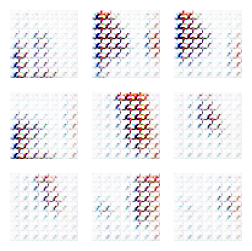

Epoch 3
Loss
Generator:1.9418559074401855
Discriminator:0.5392248034477234
Accuracy
Real Discriminator:0.7890625
Fake Discriminator:1.0
Combined Discriminator:0.89453125
Loss
Generator:2.0840859413146973
Discriminator:0.588767409324646
Accuracy
Real Discriminator:0.7578125
Fake Discriminator:1.0
Combined Discriminator:0.87890625
Loss
Generator:1.9667656421661377
Discriminator:0.6693428158760071
Accuracy
Real Discriminator:0.7734375
Fake Discriminator:0.9921875
Combined Discriminator:0.8828125
Loss
Generator:1.5214358568191528
Discriminator:0.6209219098091125
Accuracy
Real Discriminator:0.8125
Fake Discriminator:0.94140625
Combined Discriminator:0.876953125
Loss
Generator:1.3532788753509521
Discriminator:0.6403484344482422
Accuracy
Real Discriminator:0.78125
Fake Discriminator:1.0
Combined Discriminator:0.890625
Loss
Generator:1.5701440572738647
Discriminator:0.6136951446533203
Accuracy
Real Discriminator:0.7734375
Fake Discriminator:1.0
Combined Discriminator:0.88671875
Loss
Generator:

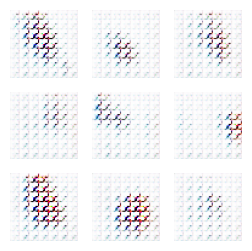

Epoch 4
Loss
Generator:1.8245521783828735
Discriminator:0.5493105053901672
Accuracy
Real Discriminator:0.8125
Fake Discriminator:1.0
Combined Discriminator:0.90625
Loss
Generator:1.9287828207015991
Discriminator:0.5843844413757324
Accuracy
Real Discriminator:0.7734375
Fake Discriminator:1.0
Combined Discriminator:0.88671875
Loss
Generator:1.9033452272415161
Discriminator:0.6217365264892578
Accuracy
Real Discriminator:0.77734375
Fake Discriminator:1.0
Combined Discriminator:0.888671875
Loss
Generator:1.6887972354888916
Discriminator:0.5580670237541199
Accuracy
Real Discriminator:0.796875
Fake Discriminator:1.0
Combined Discriminator:0.8984375
Loss
Generator:1.5558671951293945
Discriminator:0.6205601692199707
Accuracy
Real Discriminator:0.7890625
Fake Discriminator:1.0
Combined Discriminator:0.89453125
Loss
Generator:1.7434110641479492
Discriminator:0.5820029973983765
Accuracy
Real Discriminator:0.79296875
Fake Discriminator:1.0
Combined Discriminator:0.896484375
Loss
Generator:1.8617458

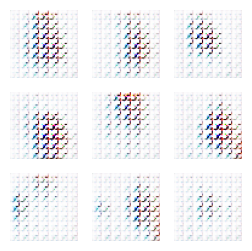

Epoch 5
Loss
Generator:2.1412711143493652
Discriminator:0.46507006883621216
Accuracy
Real Discriminator:0.82421875
Fake Discriminator:1.0
Combined Discriminator:0.912109375
Loss
Generator:2.0880448818206787
Discriminator:0.504131555557251
Accuracy
Real Discriminator:0.80859375
Fake Discriminator:1.0
Combined Discriminator:0.904296875
Loss
Generator:1.9843796491622925
Discriminator:0.5205953121185303
Accuracy
Real Discriminator:0.81640625
Fake Discriminator:1.0
Combined Discriminator:0.908203125
Loss
Generator:1.7267431020736694
Discriminator:0.5045532584190369
Accuracy
Real Discriminator:0.8359375
Fake Discriminator:1.0
Combined Discriminator:0.91796875
Loss
Generator:1.6036511659622192
Discriminator:0.5211507081985474
Accuracy
Real Discriminator:0.81640625
Fake Discriminator:1.0
Combined Discriminator:0.908203125
Loss
Generator:1.7798506021499634
Discriminator:0.5144531726837158
Accuracy
Real Discriminator:0.8125
Fake Discriminator:1.0
Combined Discriminator:0.90625
Loss
Generator:1.9

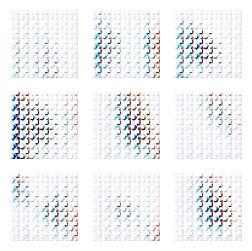

Epoch 6
Loss
Generator:2.1029069423675537
Discriminator:0.4189726710319519
Accuracy
Real Discriminator:0.83984375
Fake Discriminator:1.0
Combined Discriminator:0.919921875
Loss
Generator:2.1450157165527344
Discriminator:0.42957648634910583
Accuracy
Real Discriminator:0.828125
Fake Discriminator:1.0
Combined Discriminator:0.9140625
Loss
Generator:2.2139880657196045
Discriminator:0.44790059328079224
Accuracy
Real Discriminator:0.8046875
Fake Discriminator:1.0
Combined Discriminator:0.90234375
Loss
Generator:2.0463061332702637
Discriminator:0.4150741696357727
Accuracy
Real Discriminator:0.85546875
Fake Discriminator:1.0
Combined Discriminator:0.927734375
Loss
Generator:1.9260499477386475
Discriminator:0.43495985865592957
Accuracy
Real Discriminator:0.84375
Fake Discriminator:1.0
Combined Discriminator:0.921875
Loss
Generator:1.9506192207336426
Discriminator:0.4027807116508484
Accuracy
Real Discriminator:0.8515625
Fake Discriminator:1.0
Combined Discriminator:0.92578125


In [ ]:
train(real_image_dataset=scene_dataset,epochs=1000,gen_model=gen_model, gen_optimizer=gen_optimizer, dis_model=dis_model,
            dis_optimizer=dis_optimizer)

In [308]:
import imageio
import glob
import PIL
def display_image(epoch_no):
  return PIL.Image.open('../res/gif/image_at_epoch_{:04d}.png'.format(epoch_no))

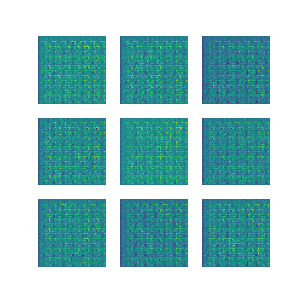

In [309]:
display_image(2)

In [298]:
anim_file = '../res/gif/gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('../res/gif/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)

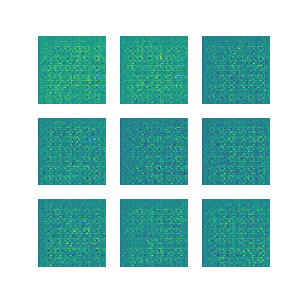

In [299]:
from PIL import Image
im = Image.open('../res/gif/gan.gif')
im